In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin
/kaggle/input/emotional-tweets/sample_submission.csv
/kaggle/input/emotional-tweets/test.csv
/kaggle/input/emotional-tweets/train.csv


## Reading data

In [2]:
train = pd.read_csv('../input/emotional-tweets/train.csv', skiprows=[5930]) # incorrect row
test = pd.read_csv('../input/emotional-tweets/test.csv',  dtype={'Id': object, 'Tweet': object})

test = test.iloc[:4000, :]

In [3]:
print(train.head())

                   Id  Category  \
0  635769805279248384  negative   
1  635930169241374720   neutral   
2  635950258682523648   neutral   
3  636030803433009153  negative   
4  636100906224848896  positive   

                                               Tweet  
0                                      Not Available  
1  IOS 9 App Transport Security. Mm need to check...  
2  Mar if you have an iOS device, you should down...  
3  @jimmie_vanagon my phone does not run on lates...  
4  Not sure how to start your publication on iOS?...  


In [4]:
print(test.head())

                   Id                                              Tweet
0  628949369883000832  dear @Microsoft the newOoffice for Mac is grea...
1  628976607420645377  @Microsoft how about you make a system that do...
2  629023169169518592                                      Not Available
3  629179223232479232                                      Not Available
4  629186282179153920  If I make a game as a #windows10 Universal App...


## Preparing model

In [5]:
import gensim, logging, re, nltk
import pandas as pd
import smart_open, os

wv = gensim.models.KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python//GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [6]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

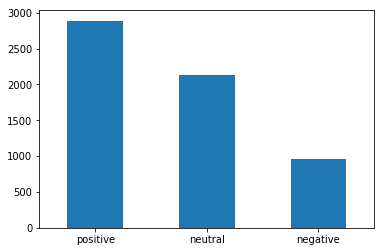

In [7]:
%matplotlib inline
train.Category.value_counts().plot(kind="bar", rot=0)

## Training - train test split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

train_data, test_data = train_test_split(train, test_size=0.2, random_state=21)

In [9]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['Tweet']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['Tweet']), axis=1).values
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

### LogisticRegression

In [10]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['Category'])
predicted = logreg.predict(X_test_word_average)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [11]:
print('Trafność klasyfikacji %s' % accuracy_score(test_data.Category, predicted))
cm = confusion_matrix(test_data.Category, predicted)
print('Macierz pomyłek\n %s' % cm)

Trafność klasyfikacji 0.5829145728643216
Macierz pomyłek
 [[ 56  73  49]
 [ 50 185 205]
 [ 17 104 455]]


### XGBoost

In [12]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(n_estimators=1000, n_jobs=-1, learning_rate=0.05, random_state=21)
xgboost.fit(X_train_word_average, train_data['Category'], verbose=False)
predicted = xgboost.predict(X_test_word_average)

In [13]:
print('Trafność klasyfikacji %s' % accuracy_score(test_data.Category, predicted))
cm = confusion_matrix(test_data.Category, predicted)
print('Macierz pomyłek\n %s' % cm)

Trafność klasyfikacji 0.5720268006700168
Macierz pomyłek
 [[ 41  85  52]
 [ 41 202 197]
 [ 12 124 440]]


### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=21)
randomForest.fit(X_train_word_average, train_data['Category'])
predicted = randomForest.predict(X_test_word_average)

In [15]:
print('Trafność klasyfikacji %s' % accuracy_score(test_data.Category, predicted))
cm = confusion_matrix(test_data.Category, predicted)
print('Macierz pomyłek\n %s' % cm)

Trafność klasyfikacji 0.567001675041876
Macierz pomyłek
 [[  3 103  72]
 [  2 187 251]
 [  1  88 487]]


## Training - cross validation

In [16]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score

# train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Tweet']), axis=1).values
# X_train_word_average = word_averaging_list(wv,train_tokenized)

### LogisticRegression

In [17]:
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(n_jobs=1, C=1e5)

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
# results = cross_val_score(logreg, X_train_word_average, train['Category'], cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

### XGBoost

In [18]:
# from xgboost import XGBClassifier

# xgboost = XGBClassifier(n_estimators=1000, n_jobs=-1, learning_rate=0.05, random_state=21)

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
# results = cross_val_score(xgboost, X_train_word_average, train['Category'], cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

### Random Forest

In [19]:
# from sklearn.ensemble import RandomForestClassifier

# randomForest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=21)

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
# results = cross_val_score(randomForest, X_train_word_average, train['Category'], cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Generate predictions

### Train best model on the whole dataset

In [20]:
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Tweet']), axis=1).values
X_train_word_average = word_averaging_list(wv,train_tokenized)
                                           
best_model = LogisticRegression(n_jobs=1, C=1e5)
best_model.fit(X_train_word_average, train['Category'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Predictions

In [21]:
final_model = best_model

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Tweet']), axis=1).values
X_test_word_average = word_averaging_list(wv,test_tokenized)

preds_test = final_model.predict(X_test_word_average)

output = pd.DataFrame({'Id': test.iloc[:, 0],
                       'Category': preds_test})

output.to_csv('submission.csv', index=False)